In [2]:
import os, glob, re
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import ramCOH.raman as ram
from ramCOH.signal_processing import functions as sf
import seaborn as sns
import sklearn.metrics as met
import matplotlib.widgets as w

import meltInc.plotting as plo

plo.layout()

os.chdir('C:/data/Dropbox/research/Azores/Raman/H2O')

In [3]:
save_files = False
files_folder = "./inclusions/raw2021"
save_as = "2021_ramanH2O"

# Data import and parsing

In [4]:
calibrationCoeffLin = pd.read_csv('C:/data/Dropbox/research/Azores/Raman/H2O/H2OcalibrationLin.csv', index_col=[0]).squeeze()

In [5]:
files = tuple([os.path.basename(x) for x in glob.glob(os.path.join(files_folder, '*.txt'))])

samples = pd.DataFrame()
samples["name"] = [x[: x.find('_')] for x in files]
samples['aquisition'] = np.zeros(samples.shape[0]) 
samples['SiArea'] = np.zeros(samples.shape[0]) 
samples['H2Oarea'] = np.zeros(samples.shape[0])   
samples['rWS'] = np.zeros(samples.shape[0])

Get aquisition times from files names

In [6]:
for i in samples.index:
    file = files[i]
    samples.loc[i, 'aquisition'] = re.search("_[\d]+s x", file)[0][1:-3]
        
samples.aquisition = samples.aquisition.astype(float)

Raman calibration line

In [7]:
H2Ocalc = lambda x: sf.H2Oraman(x, intercept=calibrationCoeffLin['intercept'], slope=calibrationCoeffLin['slope'])

H2O calibration line

In [8]:
H2Opoly = lambda x: poly3(x, **calibrationCoeffPoly)

Select samples for interpolation

In [9]:
samples_settings = pd.DataFrame({"name": [x[: x.find('_')] for x in files], "interpolate": False}, index=np.arange(0, len(files)))
samples_settings["interpolate_left"] = int(780)
samples_settings["interpolate_right"] = int(900)

## Select samples for interpolation

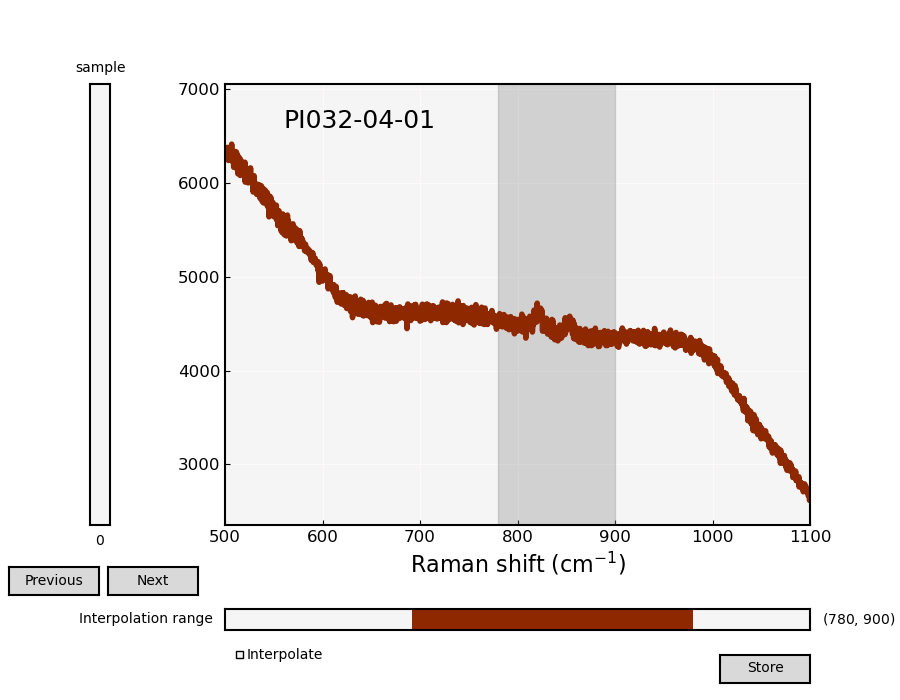

In [10]:
# Define initial parameters
init_samples = 0
init_left = samples_settings.loc[init_samples, "interpolate_left"]
init_right = samples_settings.loc[init_samples, "interpolate_right"]
init_interpolate = bool(samples_settings.loc[init_samples, "interpolate"])
# Colours for unselected and selected interpolation regions
polygon_colours = ["gray", "#468966"]

%matplotlib widget

x, y = np.genfromtxt(f"{files_folder}/{files[0]}", delimiter='\t', unpack=True)
xmin, xmax = 500, 1100
ymax = np.max(y[np.where((x > xmin) & (x < xmax))]) * 1.1
ymin = np.min(y[np.where((x > xmin) & (x < xmax))]) * 0.9

fig, ax = plt.subplots(figsize=(9,7), constrained_layout=False)

ax.set_xlabel('Raman shift (cm$^{-1})$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Plot elements
spectrum, = plt.plot(x, y)
interp_region = plt.axvspan(init_left, init_right, alpha=0.3, color=polygon_colours[init_interpolate])
label = plt.text(x=0.1, y=0.9, transform=ax.transAxes, s=samples_settings.loc[init_samples, "name"], fontsize=18)

# Horizontal slider to control interpolation region.
ax_range = plt.axes([0.25, 0.1, 0.65, 0.03])
range_slider = w.RangeSlider(
    ax=ax_range, 
    label="Interpolation range", 
    valmin=700, 
    valmax=950, 
    valinit=(init_left, init_right),
    valstep=1
)

# Vertically oriented slider to control sample selection
ax_sample = plt.axes([0.1, 0.25, 0.0225, 0.63])
sample_slider = w.Slider(
    ax=ax_sample,
    label="sample",
    valmin=0,
    valmax=len(files) - 1,
    valinit=init_samples,
    valstep=1,
    orientation="vertical"
)

# Create a checkbox for interpolation
ax_interp_checkbox = plt.axes([0.25, 0.025, 0.08, 0.08], frameon=False ,aspect='equal')
interp_checkbox = w.CheckButtons(ax=ax_interp_checkbox, labels=["Interpolate"], actives=[init_interpolate])

# Create a button to store interpolation regions.
ax_store = plt.axes([0.8, 0.025, 0.1, 0.04])
button = w.Button(ax_store, 'Store', hovercolor='0.975')

# Create buttons for moving next and previous samples.
ax_previous = plt.axes([0.01, 0.15, 0.1, 0.04])
previous_button = w.Button(ax_previous, 'Previous', hovercolor='0.975')
ax_next = plt.axes([0.12, 0.15, 0.1, 0.04])
next_button = w.Button(ax_next, 'Next', hovercolor='0.975')

def next_sample(event):
    if sample_slider.val < len(files) - 1:
        sample_slider.set_val(sample_slider.val + 1)
        
def previous_sample(event):
    if sample_slider.val > 0:
        sample_slider.set_val(sample_slider.val - 1)

# Function called when the store button is clicked
def store(event):
    idx = sample_slider.val
    left, right = range_slider.val
    samples_settings.loc[idx, "interpolate_left"] =  left
    samples_settings.loc[idx, "interpolate_right"] =  right
    samples_settings.loc[idx, "interpolate"] = interp_checkbox.get_status()[0]
    samples_settings.to_csv(f"{os.getcwd()}/{save_as}_settings.csv")

# Function called when the sample slider's value changes
def update_sample(val):
    # Load new dta
    idx = int(val)
    x, y = np.genfromtxt(f"{files_folder}/{files[idx]}", unpack=True)
    label.set(text=samples_settings.loc[idx, "name"])
    spectrum.set_data(x, y)
    # Rescale axes
    ymax = np.max(y[np.where((x > xmin) & (x < xmax))]) * 1.1
    ymin = np.min(y[np.where((x > xmin) & (x < xmax))]) * 0.9
    ax.set_ylim(ymin, ymax)
    # Reset interpolation region and checkbox
    range_slider.set_val((samples_settings.loc[idx, "interpolate_left"], samples_settings.loc[idx, "interpolate_right"]))
    interpolation_status = bool(samples_settings.loc[idx, "interpolate"])
    interp_region.set(color=polygon_colours[interpolation_status])
    if interp_checkbox.get_status()[0] ^ interpolation_status:
        interp_checkbox.set_active(0)    
    fig.canvas.draw_idle()

# Fuction called when the range slider's values change
def update_range(val):
    left, right = *val,
    interpolate_polygon = np.array([[left, 0.], [left, 1.], [right, 1.], [right, 0.]])
    interp_region.set_xy(interpolate_polygon)
    fig.canvas.draw_idle()
    
def update_checkbox(event):
    interp_region.set(color=polygon_colours[interp_checkbox.get_status()[0]])
    

# register the update function with each slider
sample_slider.on_changed(update_sample)
range_slider.on_changed(update_range)
button.on_clicked(store)
interp_checkbox.on_clicked(update_checkbox)
next_button.on_clicked(next_sample)
previous_button.on_clicked(previous_sample)

plt.show()

# Initial spectrum processing

In [11]:
samplesSpectra = {}
totalItems= samples.shape[0]-1

for j, i in enumerate(samples.index):
    
    name = samples.loc[i, "name"]
    file = files[i]
    
    print(f"{j}/{totalItems}", end= "\r")
        
    x, y = np.genfromtxt(f"{files_folder}/{file}", delimiter='\t', unpack = True)
    
    samplesSpectra[i] = ram.H2O(x, y)
    if samples_settings.loc[i, "interpolate"]:
        interpolate = [samples_settings.loc[i, "interpolate_left"], samples_settings.loc[i, "interpolate_right"]]
        samplesSpectra[i].interpolate(interpolate = interpolate)
        # print(samplesSpectra[i].interpolated_area)
    samplesSpectra[i].longCorrect()
    samplesSpectra[i].baselineCorrect()
    samplesSpectra[i].calculate_SiH2Oareas()
    
    samples.loc[i, 'SiArea'], samples.loc[i, 'H2Oarea'] = samplesSpectra[i].SiH2Oareas
    
samples['rWS'] = samples['H2Oarea'] / samples['SiArea']
samples["H2Oraman"] = H2Ocalc(samples["rWS"])

Initialise variables for individual spectrum processing

In [12]:
samples_settings["Si_bir"] = int(0)
samples_settings["water_left"] = int(2800)
samples_settings["water_right"] = int(3850)

Si_bir_0 = np.array([[20, 250], [640, 655], [800, 810], [1220, 1600]])
Si_bir_1 = np.array([[20, 250], [640, 700], [1220, 1600]])
Si_birs = [Si_bir_0, Si_bir_1]
Si_birs_labels = ["2 birs", "1 bir"]

init_samples = 0
init_water_left = int(samples_settings.loc[init_samples, "water_left"])
init_water_right = int(samples_settings.loc[init_samples, "water_right"])
init_Si_bir = int(samples_settings.loc[init_samples, "Si_bir"])

H2O_bir = np.array([[1500, init_water_left], [init_water_right, 4000]])

0

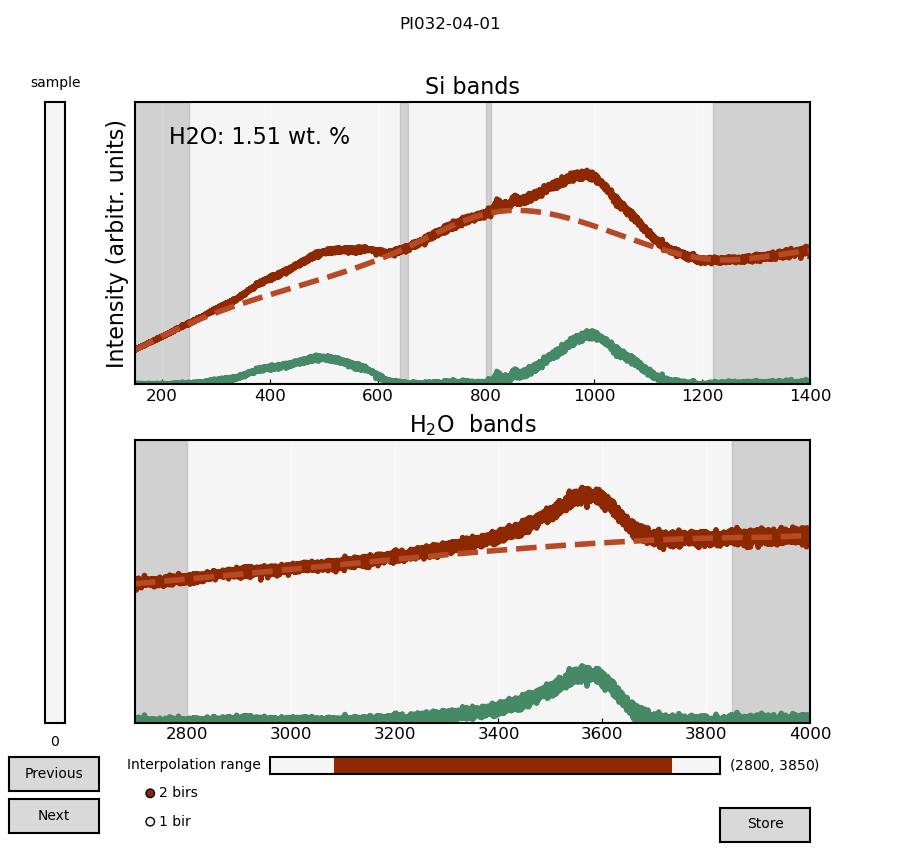

In [13]:
# Select sample
idx = samples.index[init_samples]
sample = samplesSpectra[idx]
H2O_label = samples.loc[idx, "H2Oraman"]
max_samples = samples.shape[0] - 1

# Set axes max values
ymax_Si = np.max(sample.signal.long_corrected[sample.x < 1400]) * 1.2
ymax_H2O = np.max(sample.signal.long_corrected[sample.x > 2500]) * 1.2

%matplotlib widget
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 8.5), constrained_layout=False)
# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.15, bottom=0.15)
    
title = fig.suptitle(samples.loc[idx, "name"])

# Silicate region plot
ax1.set_title("Si bands")    
ax1.set_xlabel(" ")
ax1.set_ylabel("Intensity (arbitr. units)")
ax1.set_yticks([])
ax1.set_xlim(150,1400)
ax1.set_ylim(0, ymax_Si * 1.1)

# Ax1 plot elements
H2O_label = ax1.text(x=0.05, y=0.85, transform=ax1.transAxes, s=f"H2O: {H2O_label:.2f} wt. %", fontsize=16)
Si_long_corrected, =  ax1.plot(sample.x, sample.signal.long_corrected)
Si_baseline_corrected, = ax1.plot(sample.x, sample.signal.baseline_corrected)
Si_baseline, = ax1.plot(sample.x, sample.baseline, linestyle = 'dashed')
Si_bir0_polygons = [ax1.axvspan(bir[0], bir[1], alpha=0.3, color="gray", visible=False) for bir in Si_bir_0]
Si_bir1_polygons = [ax1.axvspan(bir[0], bir[1], alpha=0.3, color="gray", visible=False) for bir in Si_bir_1]
Si_bir_polygons = [Si_bir0_polygons, Si_bir1_polygons]
for polygon in Si_bir_polygons[init_Si_bir]:
    polygon.set_visible(True)

# H2O region plot
ax2.set_title("H$_2$O  bands")    
ax2.set_yticks([])
ax2.set_xlim(2700,4000)
ax2.set_ylim(0, ymax_H2O)

H2O_long_corrected, =  ax2.plot(sample.x, sample.signal.long_corrected)
H2O_baseline_corrected, = ax2.plot(sample.x, sample.signal.baseline_corrected)
H2O_baseline, = ax2.plot(sample.x, sample.baseline, linestyle = 'dashed')
H2O_bir_polygons = [ax2.axvspan(bir[0], bir[1], alpha=0.3, color="gray") for bir in H2O_bir]

# Sample slider
ax_sample = plt.axes([0.05, 0.15, 0.0225, 0.73])
sample_slider = w.Slider(
    ax=ax_sample,
    label="sample",
    valmin=0,
    valmax=max_samples,
    valinit=init_samples,
    valstep=1,
    orientation="vertical"
)

# Silicate region birs radio buttons
Si_birs_labels = ("2 birs", "1 bir")
ax_Si_birs = plt.axes([0.05, 0.0, 0.3, 0.1], frameon=False, aspect='equal')
Si_birs_buttons = w.RadioButtons(ax=ax_Si_birs, labels=Si_birs_labels, active=init_Si_bir, activecolor="#8E2800")

# Water region birs slider
ax_water_range = plt.axes([0.3, 0.09, 0.5, 0.02])
water_range_slider = w.RangeSlider(
    ax=ax_water_range, 
    label="Interpolation range", 
    valmin=2600, 
    valmax=4000, 
    valinit=(init_water_left, init_water_right),
    valstep=10
)

# Create a button to store interpolation regions.
ax_store = plt.axes([0.8, 0.01, 0.1, 0.04])
store_button = w.Button(ax_store, 'Store', hovercolor='0.975')

# Create buttons for moving next and previous samples.
ax_previous = plt.axes([0.01, 0.07, 0.1, 0.04])
previous_button = w.Button(ax_previous, 'Previous', hovercolor='0.975')
ax_next = plt.axes([0.01, 0.02, 0.1, 0.04])
next_button = w.Button(ax_next, 'Next', hovercolor='0.975')

def next_sample(event):
    if sample_slider.val < max_samples:
        sample_slider.set_val(sample_slider.val + 1)
        
def previous_sample(event):
    if sample_slider.val > 0:
        sample_slider.set_val(sample_slider.val - 1)

# Function called when sample slider's value is changed
def update_sample(val):
    # Load new data
    idx = samples.index[int(val)]
    sample = samplesSpectra[idx]
    title.set(text=samples.loc[idx, "name"])
    # Plot silicate region
    Si_long_corrected.set_data(sample.x, sample.signal.long_corrected)
    Si_baseline_corrected.set_data(sample.x, sample.signal.baseline_corrected)
    Si_baseline.set_data(sample.x, sample.baseline)
    H2O_label.set(text=f"H2O: {samples.loc[idx, 'H2Oraman']: .2f} wt. %")
    # Plot H2O region
    H2O_long_corrected.set_data(sample.x, sample.signal.long_corrected)
    H2O_baseline_corrected.set_data(sample.x, sample.signal.baseline_corrected)
    H2O_baseline.set_data(sample.x, sample.baseline)
    # Reset widgets
    water_range_slider.set_val((int(samples_settings.loc[idx, "water_left"]), int(samples_settings.loc[idx, "water_right"])))
    Si_birs_buttons.set_active(int(samples_settings.loc[idx, "Si_bir"]))
    # Rescale axes
    ymax_Si = np.max(sample.signal.long_corrected[sample.x < 1400]) * 1.2
    ymax_H2O = np.max(sample.signal.long_corrected[sample.x > 2500]) * 1.2
    ax1.set_ylim(0, ymax_Si)
    ax2.set_ylim(0, ymax_H2O)
                      
    fig.canvas.draw_idle()
    
def update_bir(event):
    # Get new birs
    idx = samples.index[int(sample_slider.val)]
    Si_bir_idx = Si_birs_labels.index(Si_birs_buttons.value_selected)
    water_left, water_right = *water_range_slider.val,
    H2O_bir = np.array([[1500, water_left], [water_right, 4000]])
    birs = np.concatenate((Si_birs[Si_bir_idx], H2O_bir))
    # Calculate new baseline
    samplesSpectra[idx].baselineCorrect(y="long_corrected", baseline_regions=birs, smooth_factor=1)    
    Si_baseline_corrected.set_data(samplesSpectra[idx].x, samplesSpectra[idx].signal.baseline_corrected)
    Si_baseline.set_data(samplesSpectra[idx].x, samplesSpectra[idx].baseline)
    # Redraw birs
    for polygon in Si_bir_polygons[Si_bir_idx]:
        polygon.set_visible(True)
    for polygon in Si_bir_polygons[abs(Si_bir_idx - 1)]:
        polygon.set_visible(False)
    
    fig.canvas.draw_idle()
    
def update_water_range(val):
    idx = samples.index[int(sample_slider.val)]
    # Get new water region birs
    water_left, water_right = *val,
    Si_bir_idx = Si_birs_labels.index(Si_birs_buttons.value_selected)
    H2O_bir = np.array([[1500, water_left], [water_right, 4000]])
    birs = np.concatenate((Si_birs[Si_bir_idx], H2O_bir))
    # Calculate new baseline
    samplesSpectra[idx].baselineCorrect(y="long_corrected", baseline_regions=birs, smooth_factor=1)    
    H2O_baseline_corrected.set_data(samplesSpectra[idx].x, samplesSpectra[idx].signal.baseline_corrected)
    H2O_baseline.set_data(samplesSpectra[idx].x, samplesSpectra[idx].baseline)    
    # Create new polygons
    polygon_left = np.array([[1500, 0.], [1500, 1.], [water_left, 1.], [water_left, 0.]])
    polygon_right = np.array([[water_right, 0.], [water_right, 1.], [4000, 1.], [4000, 0.]])
    H2O_polygons = [polygon_left, polygon_right]
    # Update coordinates
    for polygon_old, polygon_new in zip(H2O_bir_polygons, H2O_polygons):
        polygon_old.set_xy(polygon_new)
        
    fig.canvas.draw_idle()

def store(event):
    idx = samples.index[int(sample_slider.val)]
    # Store settings
    water_left, water_right = *water_range_slider.val,
    bir_idx = Si_birs_labels.index(Si_birs_buttons.value_selected)
    samples_settings.loc[idx, "Si_bir"] = bir_idx
    samples_settings.loc[idx, "water_left"] = water_left
    samples_settings.loc[idx, "water_right"] = water_right
    # Store results
    samplesSpectra[idx].calculate_SiH2Oareas()
    samples.loc[idx, 'SiArea'], samples.loc[idx, 'H2Oarea'] = samplesSpectra[idx].SiH2Oareas    
    samples['rWS'] = samples['H2Oarea'] / samples['SiArea']
    samples["H2Oraman"] = H2Ocalc(samples["rWS"])
    # Export results
    samples_settings.to_csv(f"{os.getcwd()}/{save_as}_settings.csv")
    samples.to_csv(f"{os.getcwd()}/{save_as}_glasses.csv")
    
    H2O_label.set(text=f"H2O: {samples.loc[idx, 'H2Oraman']: .2f} wt. %")
              
    fig.canvas.draw_idle()    

# Register the update function with each slider
sample_slider.on_changed(update_sample)
Si_birs_buttons.on_clicked(update_bir)
water_range_slider.on_changed(update_water_range)
store_button.on_clicked(store)
previous_button.on_clicked(previous_sample)
next_button.on_clicked(next_sample)

# Validation

In [27]:
RMSE = np.sqrt(mean_squared_error(samples['H2Oraman'], samples['H2Osims']))
print(f"RMSE: {RMSE: .2f}")

RMSE:  0.13


## Validation plot

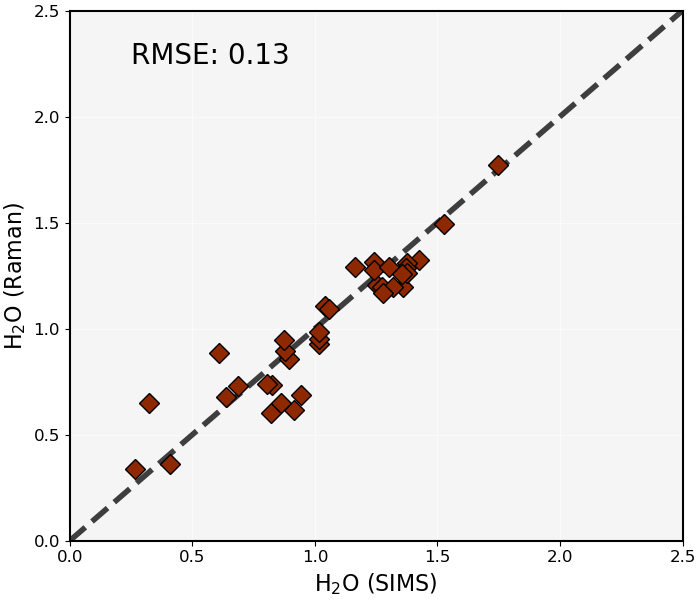

In [28]:
max_xy = 2.5

plt.figure(figsize=(7,6), constrained_layout = True) #3.25, 6.5

plt.plot([0,8], [0,8], linestyle = 'dashed', color = 'black', alpha = 0.75)
plt.plot(samples['H2Osims'], samples['H2Oraman'], "D")
plt.text(x = 0.1*max_xy, y = 0.9*max_xy, s = 'RMSE: '+str(np.round(RMSE, 2)), fontsize = 20)

plt.xlabel(r"H$_2$O (SIMS)")
plt.ylabel(r"H$_2$O (Raman)")
plt.xlim(0,max_xy)
plt.ylim(0,max_xy)
# plt.legend(loc = 'lower right')

plt.savefig('H2OsimsRaman.png', dpi= 150)

plt.show()

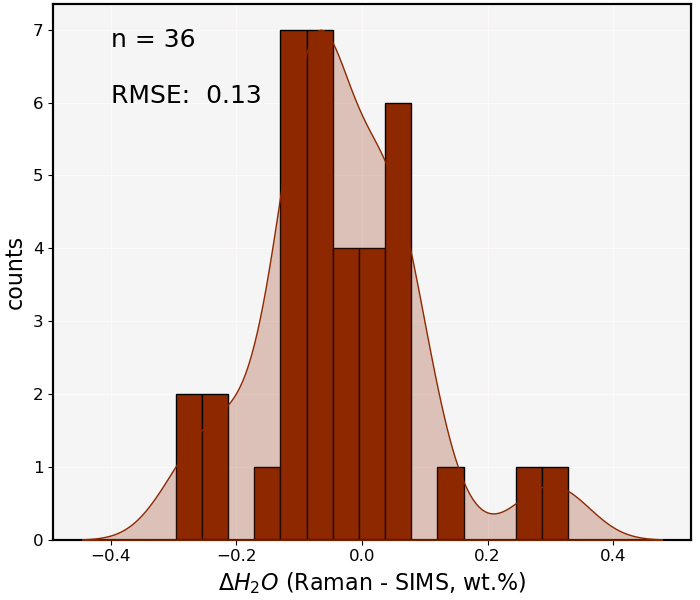

In [30]:
fig, ax = plt.subplots(figsize = (7,6), constrained_layout = True)
ax2 = ax.twinx()

ax.hist(samples['H2Oraman'] - samples['H2Osims'], bins= 15, ec= 'black')
sns.kdeplot(samples['H2Oraman'] - samples['H2Osims'], clip = (-0.75,0.8), bw_adjust = 0.8, shade = True, zorder = 10, ax = ax2)

ax.text(x= -0.4 , y= 6, s= f'n = {samples.shape[0]}\n\nRMSE: {RMSE: .2f}', size= 18)

# ax.set_yticks([])
ax.set_xlabel('$\Delta H_2O$ (Raman - SIMS, wt.%)')
ax.set_ylabel('counts')
ax2.set_yticks([])
ax2.set_ylabel(None)

# plt.savefig('deltaH2O.png', dpi = 300)
plt.show()